Load and normalizing

12298 1020
stemless gentian californian poppy globe-flower pink quill
[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


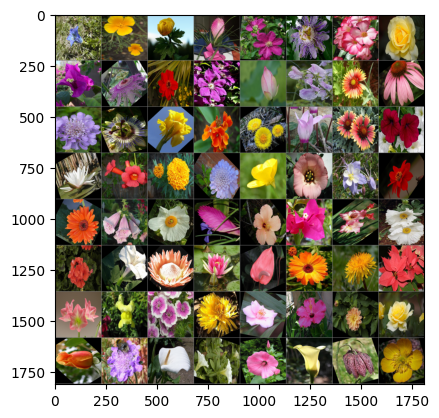

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import ssl
import urllib.request

# 禁用SSL驗證
ssl._create_default_https_context = ssl._create_unverified_context

# load data augmentation
transform1 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([224,224]),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomRotation(degrees=45),
     transforms.Resize([224,224]),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

trainset1 = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=transform1)
trainset2 = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=transform2)
trainset = ConcatDataset([trainset1, trainset2])
testset = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=transform1)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

classes = ('pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily')

# print data quantity
trainset_count = len(trainset)
testset_count = len(testset)
print(trainset_count,testset_count)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    
    # unnormalize，確保從[-1,1]變成[0,1]
    img = img / 2 + 0.5
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# confirm device
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

Define a Convolution Neural Network

In [2]:
import torch.nn as nn
import torch.nn.functional as F

# residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# ResNet模型
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
#         self.fc2 = nn.Linear(250, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
#         x = F.relu(self.fc(x))
        x = self.fc(x)  #x=self.fc2(x)

        return x

# create resnet34
def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# resnet34 instance
model = ResNet34(num_classes=102)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Define a Loss function and optimizer

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

Train


Epoch:1
	Batch:193 of 193, loss:2.751
Accuracy of the network on the test images: 23.04 %

Epoch:2
	Batch:193 of 193, loss:2.495
Accuracy of the network on the test images: 34.02 %

Epoch:3
	Batch:193 of 193, loss:1.718
Accuracy of the network on the test images: 34.71 %

Epoch:4
	Batch:193 of 193, loss:1.199
Accuracy of the network on the test images: 49.12 %

Epoch:5
	Batch:193 of 193, loss:1.710
Accuracy of the network on the test images: 43.82 %

Epoch:6
	Batch:193 of 193, loss:1.525
Accuracy of the network on the test images: 53.04 %

Epoch:7
	Batch:193 of 193, loss:1.061
Accuracy of the network on the test images: 61.86 %

Epoch:8
	Batch:193 of 193, loss:0.831
Accuracy of the network on the test images: 59.22 %

Epoch:9
	Batch:193 of 193, loss:0.780
Accuracy of the network on the test images: 56.76 %

Epoch:10
	Batch:193 of 193, loss:0.157
Accuracy of the network on the test images: 65.69 %

Epoch:11
	Batch:193 of 193, loss:0.394
Accuracy of the network on the test images: 61.76

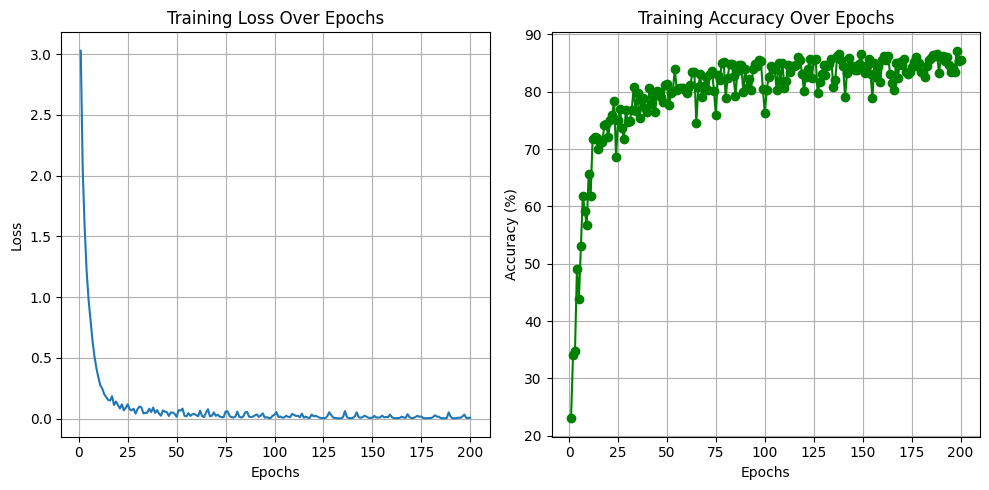

In [4]:
def train_model(model, criterion, optimizer, num_epochs):
    
    # store loss、accuracy history
    loss_history = []
    accuracy_history = []  
    early_stop_patience = 5
    best_validation_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.cuda()
        model.train()
       
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].cuda(), data[1].cuda()

            optimizer.zero_grad()

            outputs = model(inputs).cuda()
            loss = criterion(outputs, labels).cuda()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

        # store after evert epoch finished
        loss_history.append(running_loss / len(trainloader))

        # calculate accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)  

        print(f'\nAccuracy of the network on the test images: {accuracy:.2f} %')

        # checkpoint
        if (epoch + 1) % 5 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_history': loss_history,
                'accuracy_history': accuracy_history  
            }
            checkpoint_filename = f'pth/resnet34_checkpoint_epoch{epoch+1}.pth'
            torch.save(checkpoint, checkpoint_filename)

    print('\nTraining finished')
    return loss_history, accuracy_history


# 訓練model
loss_history, accuracy_history = train_model(model, criterion, optimizer, num_epochs=200)


import matplotlib.pyplot as plt

# 畫圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-',color="green")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid()

plt.tight_layout()
plt.show()


Test

GroundTruth:  pink primrose pink primrose pink primrose pink primrose pink primrose pink primrose pink primrose pink primrose pink primrose pink primrose
Predicted:  pink primrose pink primrose bougainvillea pink primrose pink primrose pink primrose pincushion flower pink primrose pink primrose bougainvillea
Accuracy of pink primrose : 70.00 %
Accuracy of hard-leaved pocket orchid : 100.00 %
Accuracy of canterbury bells : 10.00 %
Accuracy of sweet pea : 50.00 %
Accuracy of english marigold : 90.00 %
Accuracy of tiger lily : 90.00 %
Accuracy of moon orchid : 100.00 %
Accuracy of bird of paradise : 100.00 %
Accuracy of monkshood : 100.00 %
Accuracy of globe thistle : 100.00 %
Accuracy of snapdragon : 80.00 %
Accuracy of colt's foot : 90.00 %
Accuracy of king protea : 70.00 %
Accuracy of spear thistle : 90.00 %
Accuracy of yellow iris : 80.00 %
Accuracy of globe-flower : 50.00 %
Accuracy of purple coneflower : 100.00 %
Accuracy of peruvian lily : 70.00 %
Accuracy of balloon flower : 90.00

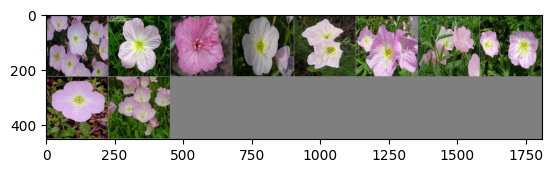

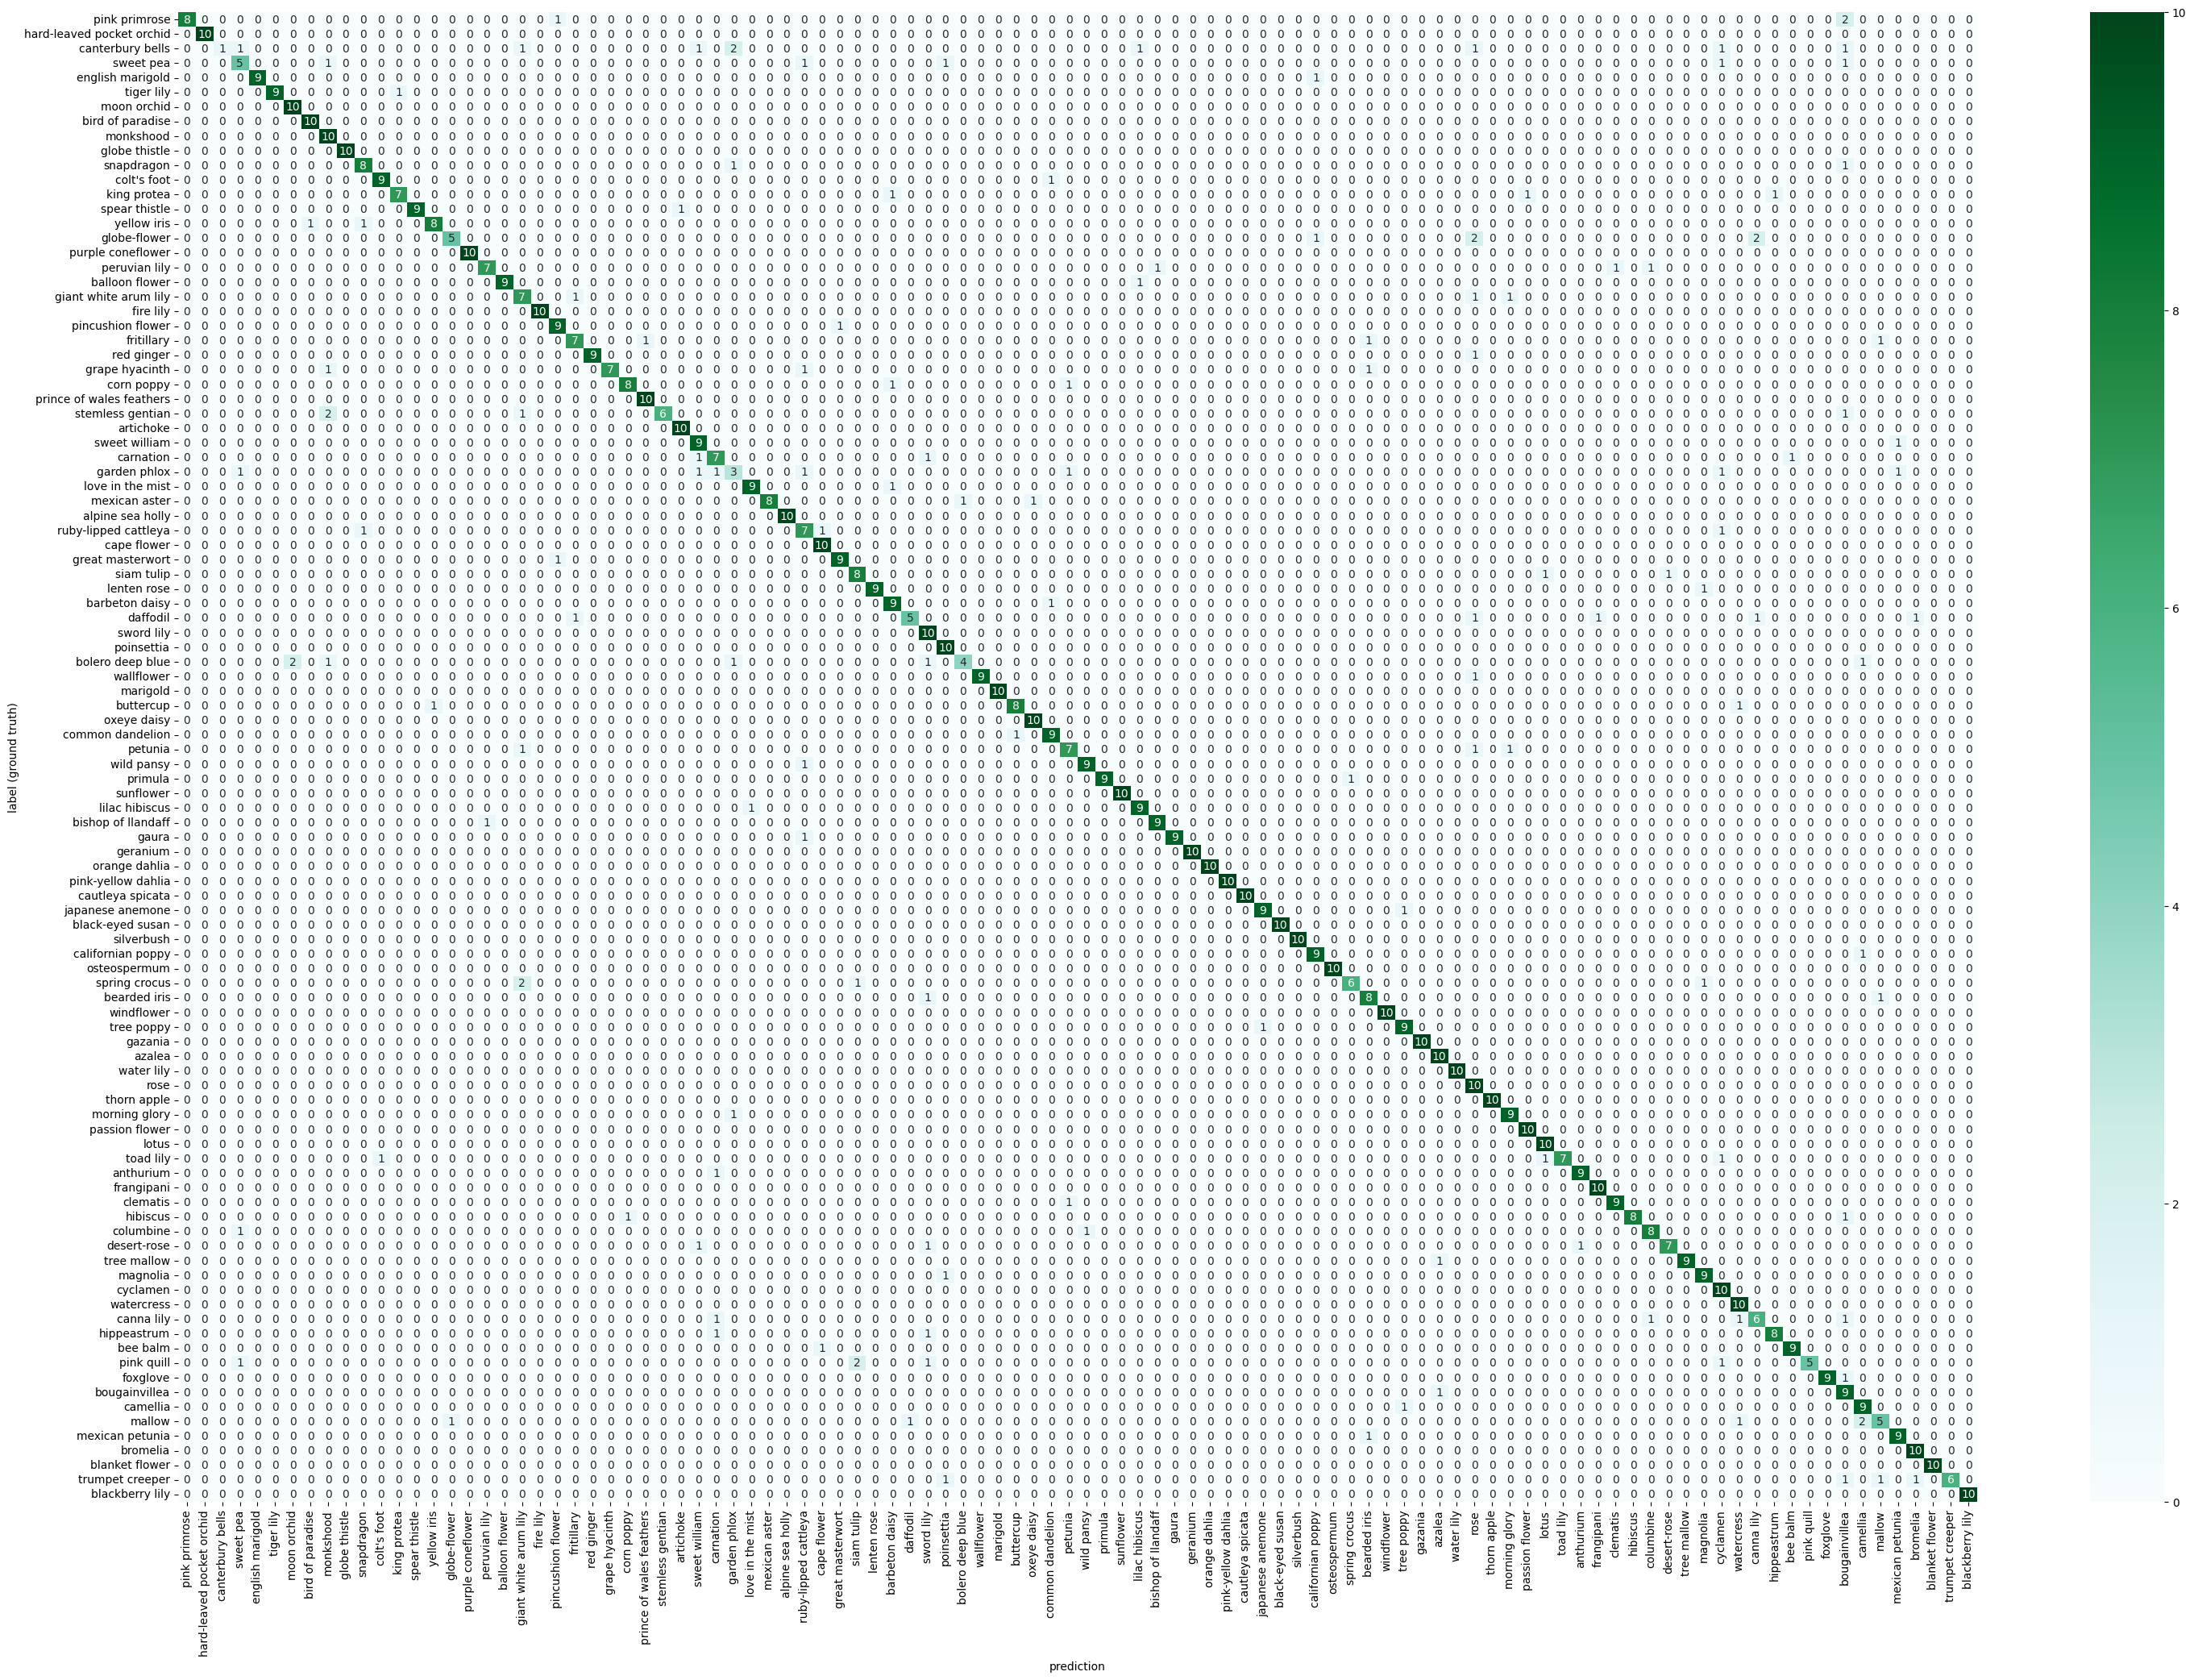

In [5]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print test images
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%10s' % classes[labels[j]] for j in range(10)))

model.eval()

# print test的預測結果
# 訓練好不用計算梯度減少資源
with torch.no_grad():
  outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

# Initialize class_correct and class_total for Flowers102 (102 classes)
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

# Initialize arrays to store predictions and ground truth
preds = np.zeros((1))
truth = np.zeros((1))

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(len(labels)):
            label = labels[i].item()  # Convert label tensor to an integer
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print accuracy for each class
for i in range(len(labels)):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %s : %.2f %%' % (classes[i], accuracy))
    else:
        print('No samples for class %s' % classes[i])

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (36,24))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")



from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))


Define a Convolution Neural Network(Sigmoid)

In [6]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    # 使用 Sigmoid 替代 ReLU
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()  
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.sigmoid(out)  

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.sigmoid(out)  

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.sigmoid = nn.Sigmoid()  
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.sigmoid(x)  
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  

        return x

def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


model = ResNet34(num_classes=102)


In [7]:
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Train


Epoch:1
	Batch:193 of 193, loss:3.877
Accuracy of the network on the test images: 2.45 %

Epoch:2
	Batch:193 of 193, loss:4.161
Accuracy of the network on the test images: 2.65 %

Epoch:3
	Batch:193 of 193, loss:3.357
Accuracy of the network on the test images: 2.35 %

Epoch:4
	Batch:193 of 193, loss:3.237
Accuracy of the network on the test images: 2.65 %

Epoch:5
	Batch:193 of 193, loss:3.988
Accuracy of the network on the test images: 2.55 %

Epoch:6
	Batch:193 of 193, loss:4.054
Accuracy of the network on the test images: 5.39 %

Epoch:7
	Batch:193 of 193, loss:3.331
Accuracy of the network on the test images: 6.57 %

Epoch:8
	Batch:193 of 193, loss:3.044
Accuracy of the network on the test images: 2.94 %

Epoch:9
	Batch:193 of 193, loss:2.999
Accuracy of the network on the test images: 4.61 %

Epoch:10
	Batch:193 of 193, loss:2.488
Accuracy of the network on the test images: 5.78 %

Epoch:11
	Batch:193 of 193, loss:3.290
Accuracy of the network on the test images: 6.96 %

Epoch:1

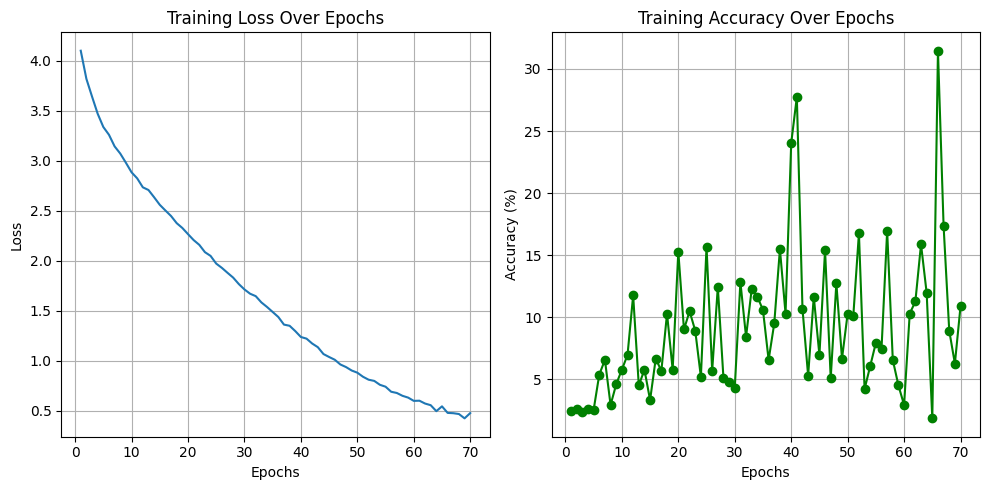

In [8]:
def train_model(model, criterion, optimizer, num_epochs):
    loss_history = []
    accuracy_history = []  
    early_stop_patience = 5
    best_validation_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.cuda()
        model.train()
       
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].cuda(), data[1].cuda()

            optimizer.zero_grad()

            outputs = model(inputs).cuda()
            loss = criterion2(outputs, labels).cuda()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

        loss_history.append(running_loss / len(trainloader))

        # calculate accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy) 

        print(f'\nAccuracy of the network on the test images: {accuracy:.2f} %')
    print('\nTraining finished')
    return loss_history, accuracy_history

loss_history, accuracy_history = train_model(model, criterion, optimizer, num_epochs=70)


import matplotlib.pyplot as plt

# 畫圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-',color="green")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid()

plt.tight_layout()
plt.show()


Test

Text(420.72222222222223, 0.5, 'label (ground truth)')

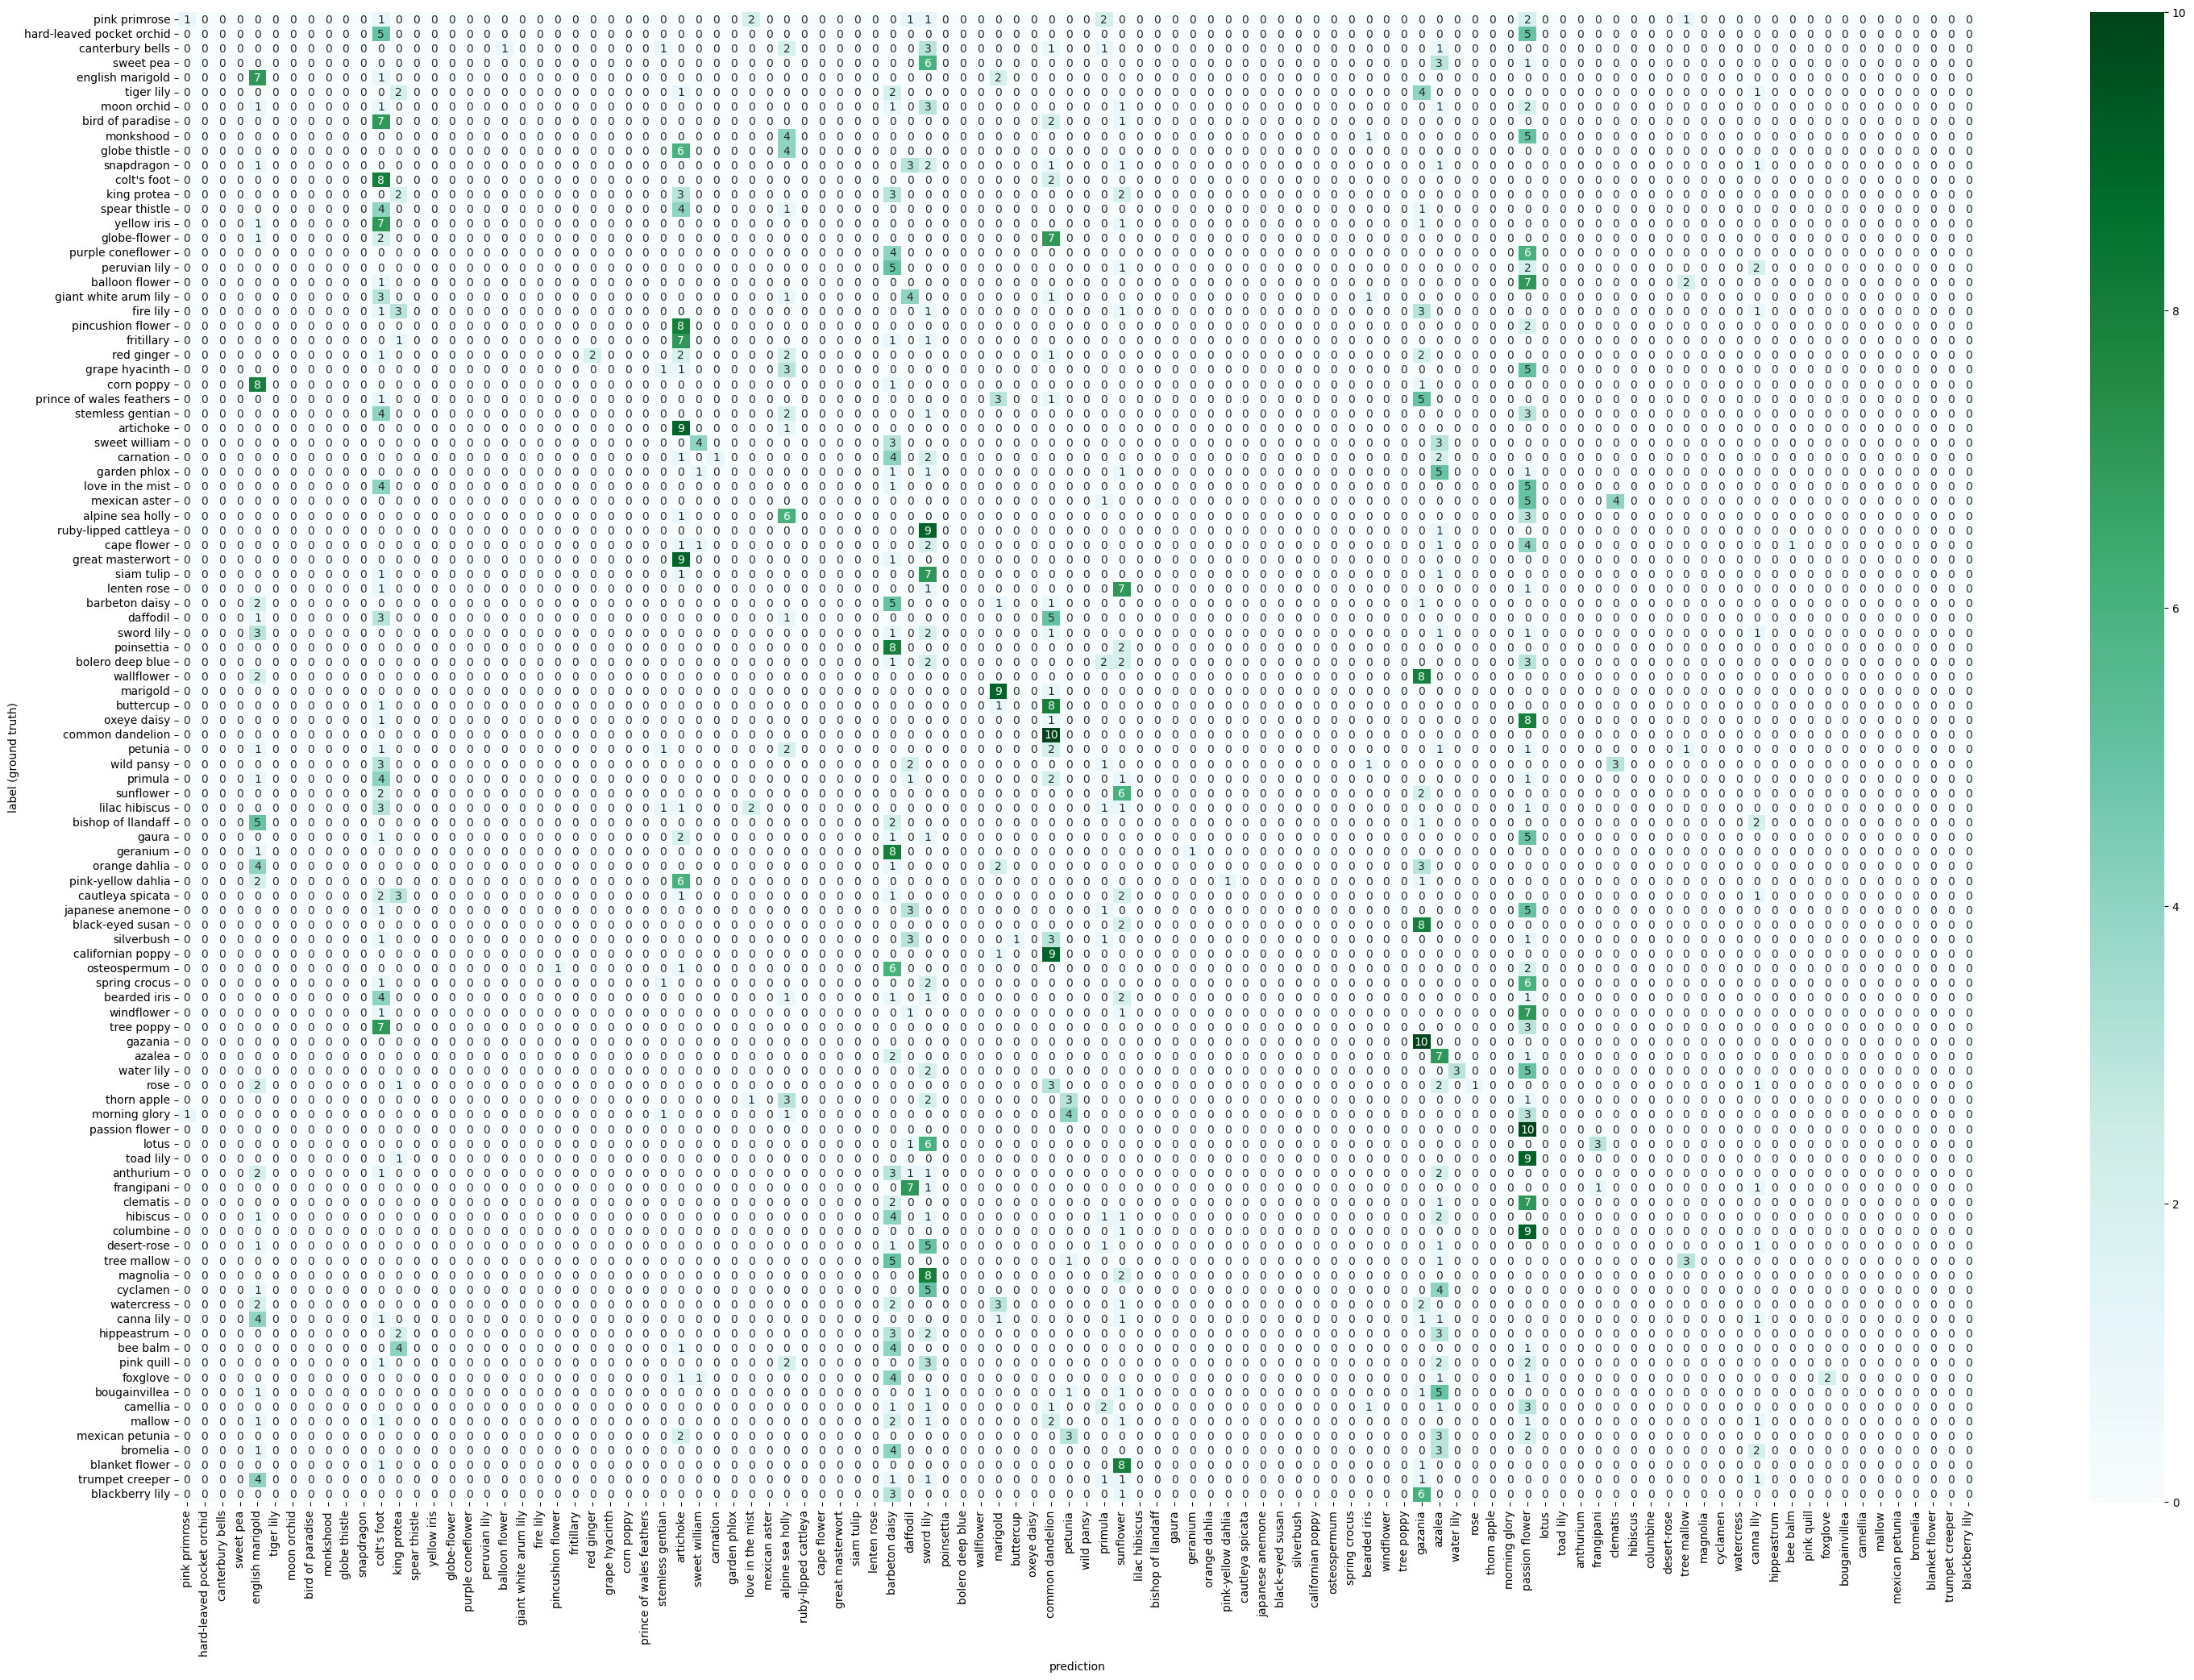

In [9]:
model.eval()

# Initialize arrays to store predictions and ground truth
preds = np.zeros((1))
truth = np.zeros((1))

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(len(labels)):
            label = labels[i].item()  # Convert label tensor to an integer
            class_correct[label] += c[i].item()
            class_total[label] += 1

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (36,24))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")



Define a Convolution Neural Network(ELU)

In [10]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.01, inplace=True)  # 使用 LeakyReLU 替代 ReLU
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# ResNet模型
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(0.01, inplace=True)  # 使用 LeakyReLU 替代 ReLU
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  

        return x

def ResNet34_L(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

model = ResNet34_L(num_classes=102)


In [11]:
criterion3 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Train


Epoch:1
	Batch:193 of 193, loss:3.012
Accuracy of the network on the test images: 17.84 %

Epoch:2
	Batch:193 of 193, loss:2.204
Accuracy of the network on the test images: 26.47 %

Epoch:3
	Batch:193 of 193, loss:1.751
Accuracy of the network on the test images: 39.22 %

Epoch:4
	Batch:193 of 193, loss:2.616
Accuracy of the network on the test images: 44.71 %

Epoch:5
	Batch:193 of 193, loss:2.142
Accuracy of the network on the test images: 49.51 %

Epoch:6
	Batch:193 of 193, loss:0.286
Accuracy of the network on the test images: 52.84 %

Epoch:7
	Batch:193 of 193, loss:1.373
Accuracy of the network on the test images: 55.10 %

Epoch:8
	Batch:193 of 193, loss:0.949
Accuracy of the network on the test images: 55.59 %

Epoch:9
	Batch:193 of 193, loss:0.484
Accuracy of the network on the test images: 65.00 %

Epoch:10
	Batch:193 of 193, loss:0.490
Accuracy of the network on the test images: 65.10 %

Epoch:11
	Batch:193 of 193, loss:0.221
Accuracy of the network on the test images: 60.98

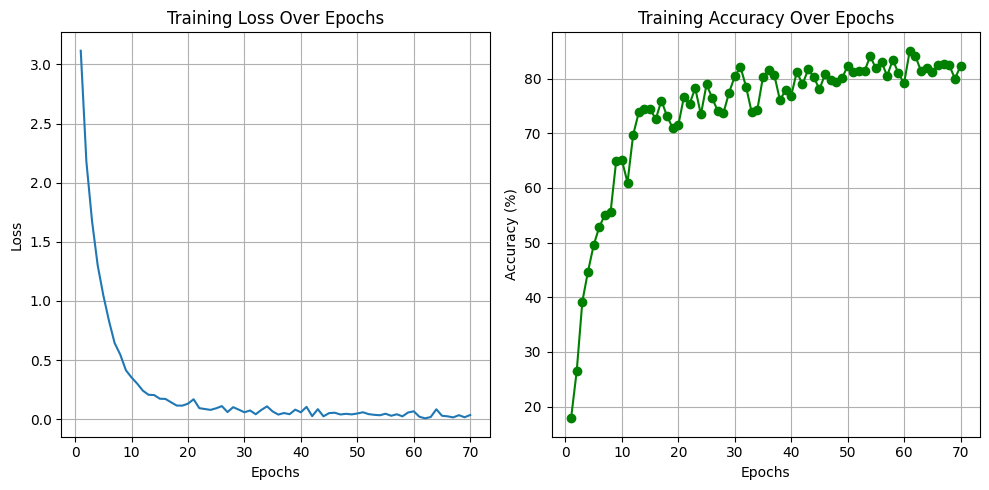

In [12]:
def train_model(model, criterion, optimizer, num_epochs):
    loss_history = []
    accuracy_history = []  
    early_stop_patience = 5
    best_validation_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.cuda()
        model.train()
       
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].cuda(), data[1].cuda()

            optimizer.zero_grad()

            outputs = model(inputs).cuda()
            loss = criterion3(outputs, labels).cuda()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

      
        loss_history.append(running_loss / len(trainloader))

        # calculate accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)  

        print(f'\nAccuracy of the network on the test images: {accuracy:.2f} %')

    print('\nTraining finished')
    return loss_history, accuracy_history


loss_history, accuracy_history = train_model(model, criterion, optimizer, num_epochs=70)


import matplotlib.pyplot as plt

# 畫圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-',color="green")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid()

plt.tight_layout()
plt.show()


Test

Text(420.72222222222223, 0.5, 'label (ground truth)')

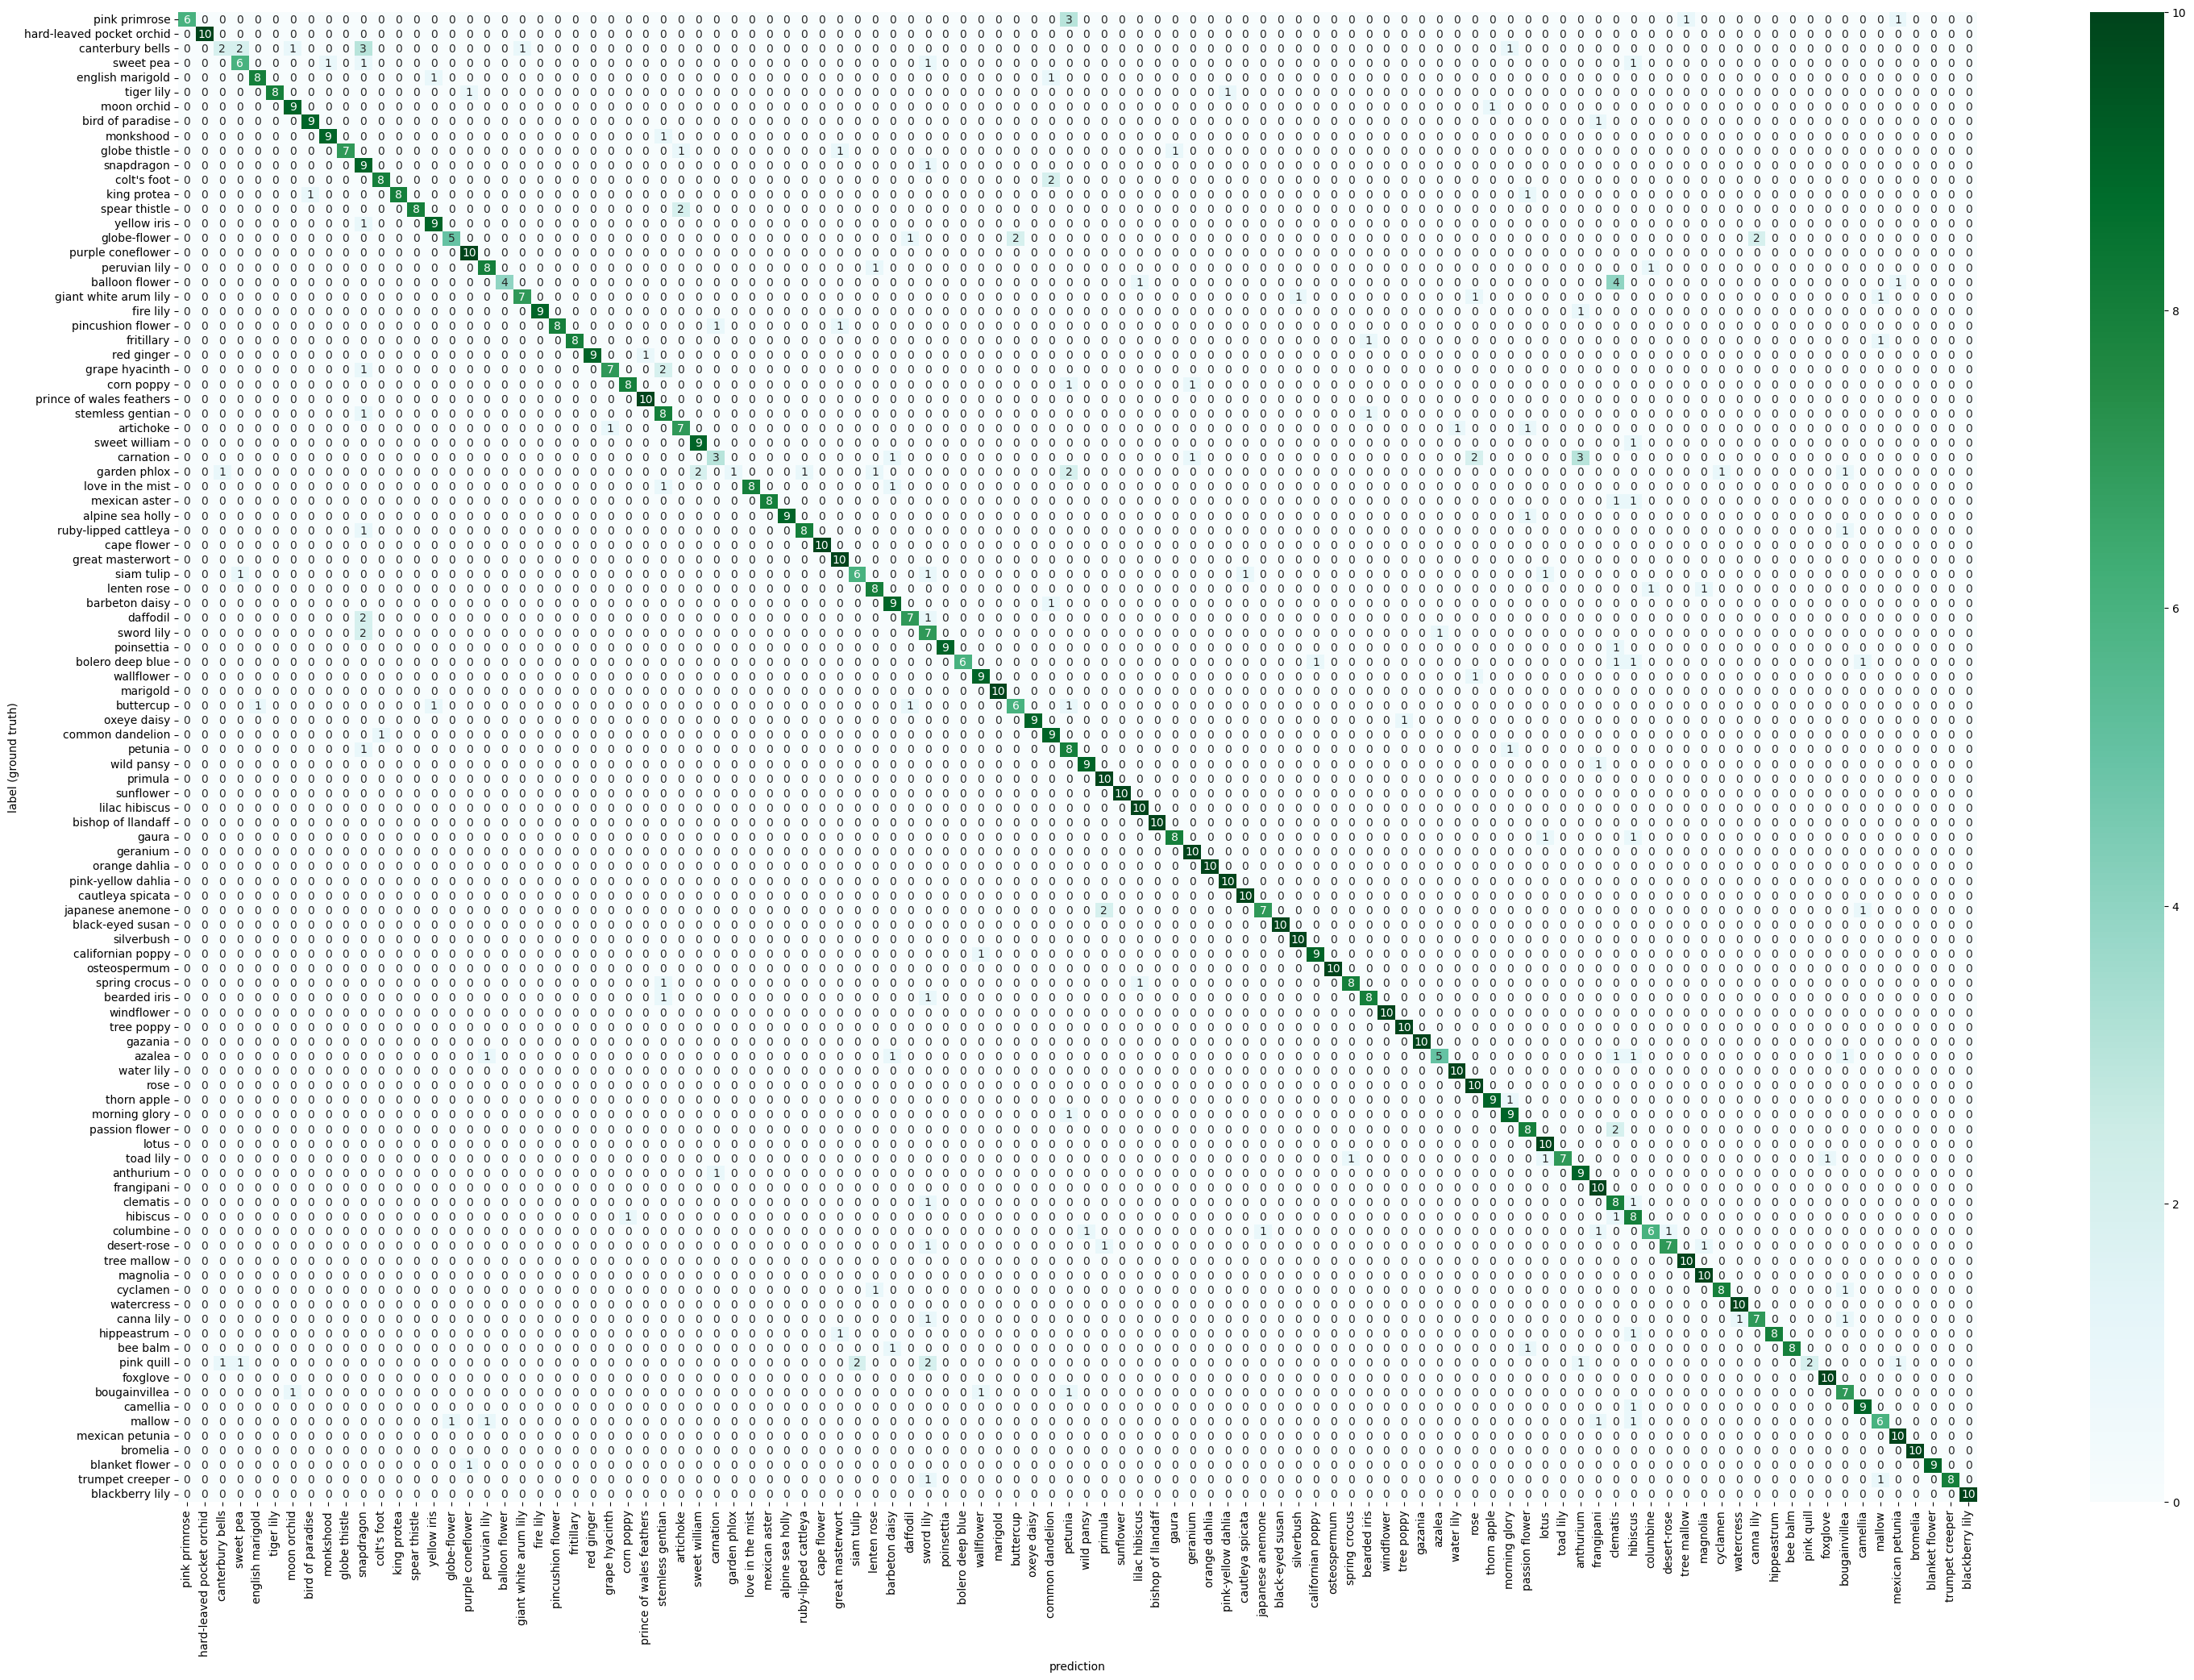

In [13]:
model.eval()

# Initialize arrays to store predictions and ground truth
preds = np.zeros((1))
truth = np.zeros((1))

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(len(labels)):
            label = labels[i].item()  # Convert label tensor to an integer
            class_correct[label] += c[i].item()
            class_total[label] += 1



import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (36,24))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")



Define a Convolution Neural Network(ReLU)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# ResNet模型
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
#         self.fc2 = nn.Linear(250, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
#         x = F.relu(self.fc(x))
        x = self.fc(x)  #x=self.fc2(x)

        return x

# create resnet34
def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# renet34 instance
model = ResNet34(num_classes=102)


In [15]:
criterion4 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Train


Epoch:1
	Batch:193 of 193, loss:3.215
Accuracy of the network on the test images: 19.80 %

Epoch:2
	Batch:193 of 193, loss:2.230
Accuracy of the network on the test images: 29.90 %

Epoch:3
	Batch:193 of 193, loss:1.945
Accuracy of the network on the test images: 35.29 %

Epoch:4
	Batch:193 of 193, loss:1.266
Accuracy of the network on the test images: 50.69 %

Epoch:5
	Batch:193 of 193, loss:2.523
Accuracy of the network on the test images: 51.76 %

Epoch:6
	Batch:193 of 193, loss:1.755
Accuracy of the network on the test images: 54.51 %

Epoch:7
	Batch:193 of 193, loss:1.358
Accuracy of the network on the test images: 60.00 %

Epoch:8
	Batch:193 of 193, loss:1.637
Accuracy of the network on the test images: 61.57 %

Epoch:9
	Batch:193 of 193, loss:0.524
Accuracy of the network on the test images: 61.96 %

Epoch:10
	Batch:193 of 193, loss:0.756
Accuracy of the network on the test images: 64.22 %

Epoch:11
	Batch:193 of 193, loss:0.509
Accuracy of the network on the test images: 63.82

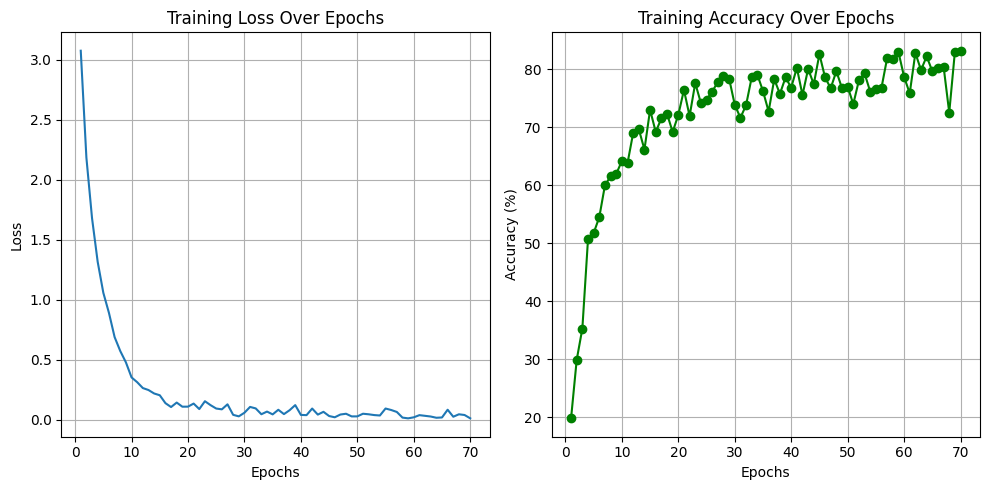

In [16]:
def train_model(model, criterion, optimizer, num_epochs):
    loss_history = []
    accuracy_history = []  
    early_stop_patience = 5
    best_validation_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.cuda()
        model.train()
       
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].cuda(), data[1].cuda()

            optimizer.zero_grad()

            outputs = model(inputs).cuda()
            loss = criterion4(outputs, labels).cuda()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

        loss_history.append(running_loss / len(trainloader))

        # calculate accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)  

        print(f'\nAccuracy of the network on the test images: {accuracy:.2f} %')

        if (epoch + 1) % 5 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_history': loss_history,
                'accuracy_history': accuracy_history  
            }
            checkpoint_filename = f'pth/resnet34_checkpoint_epoch{epoch+1}.pth'
            torch.save(checkpoint, checkpoint_filename)

    print('\nTraining finished')
    return loss_history, accuracy_history

loss_history, accuracy_history = train_model(model, criterion, optimizer, num_epochs=70)


import matplotlib.pyplot as plt

# 畫圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-',color="green")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid()

plt.tight_layout()
plt.show()


Test

Text(420.72222222222223, 0.5, 'label (ground truth)')

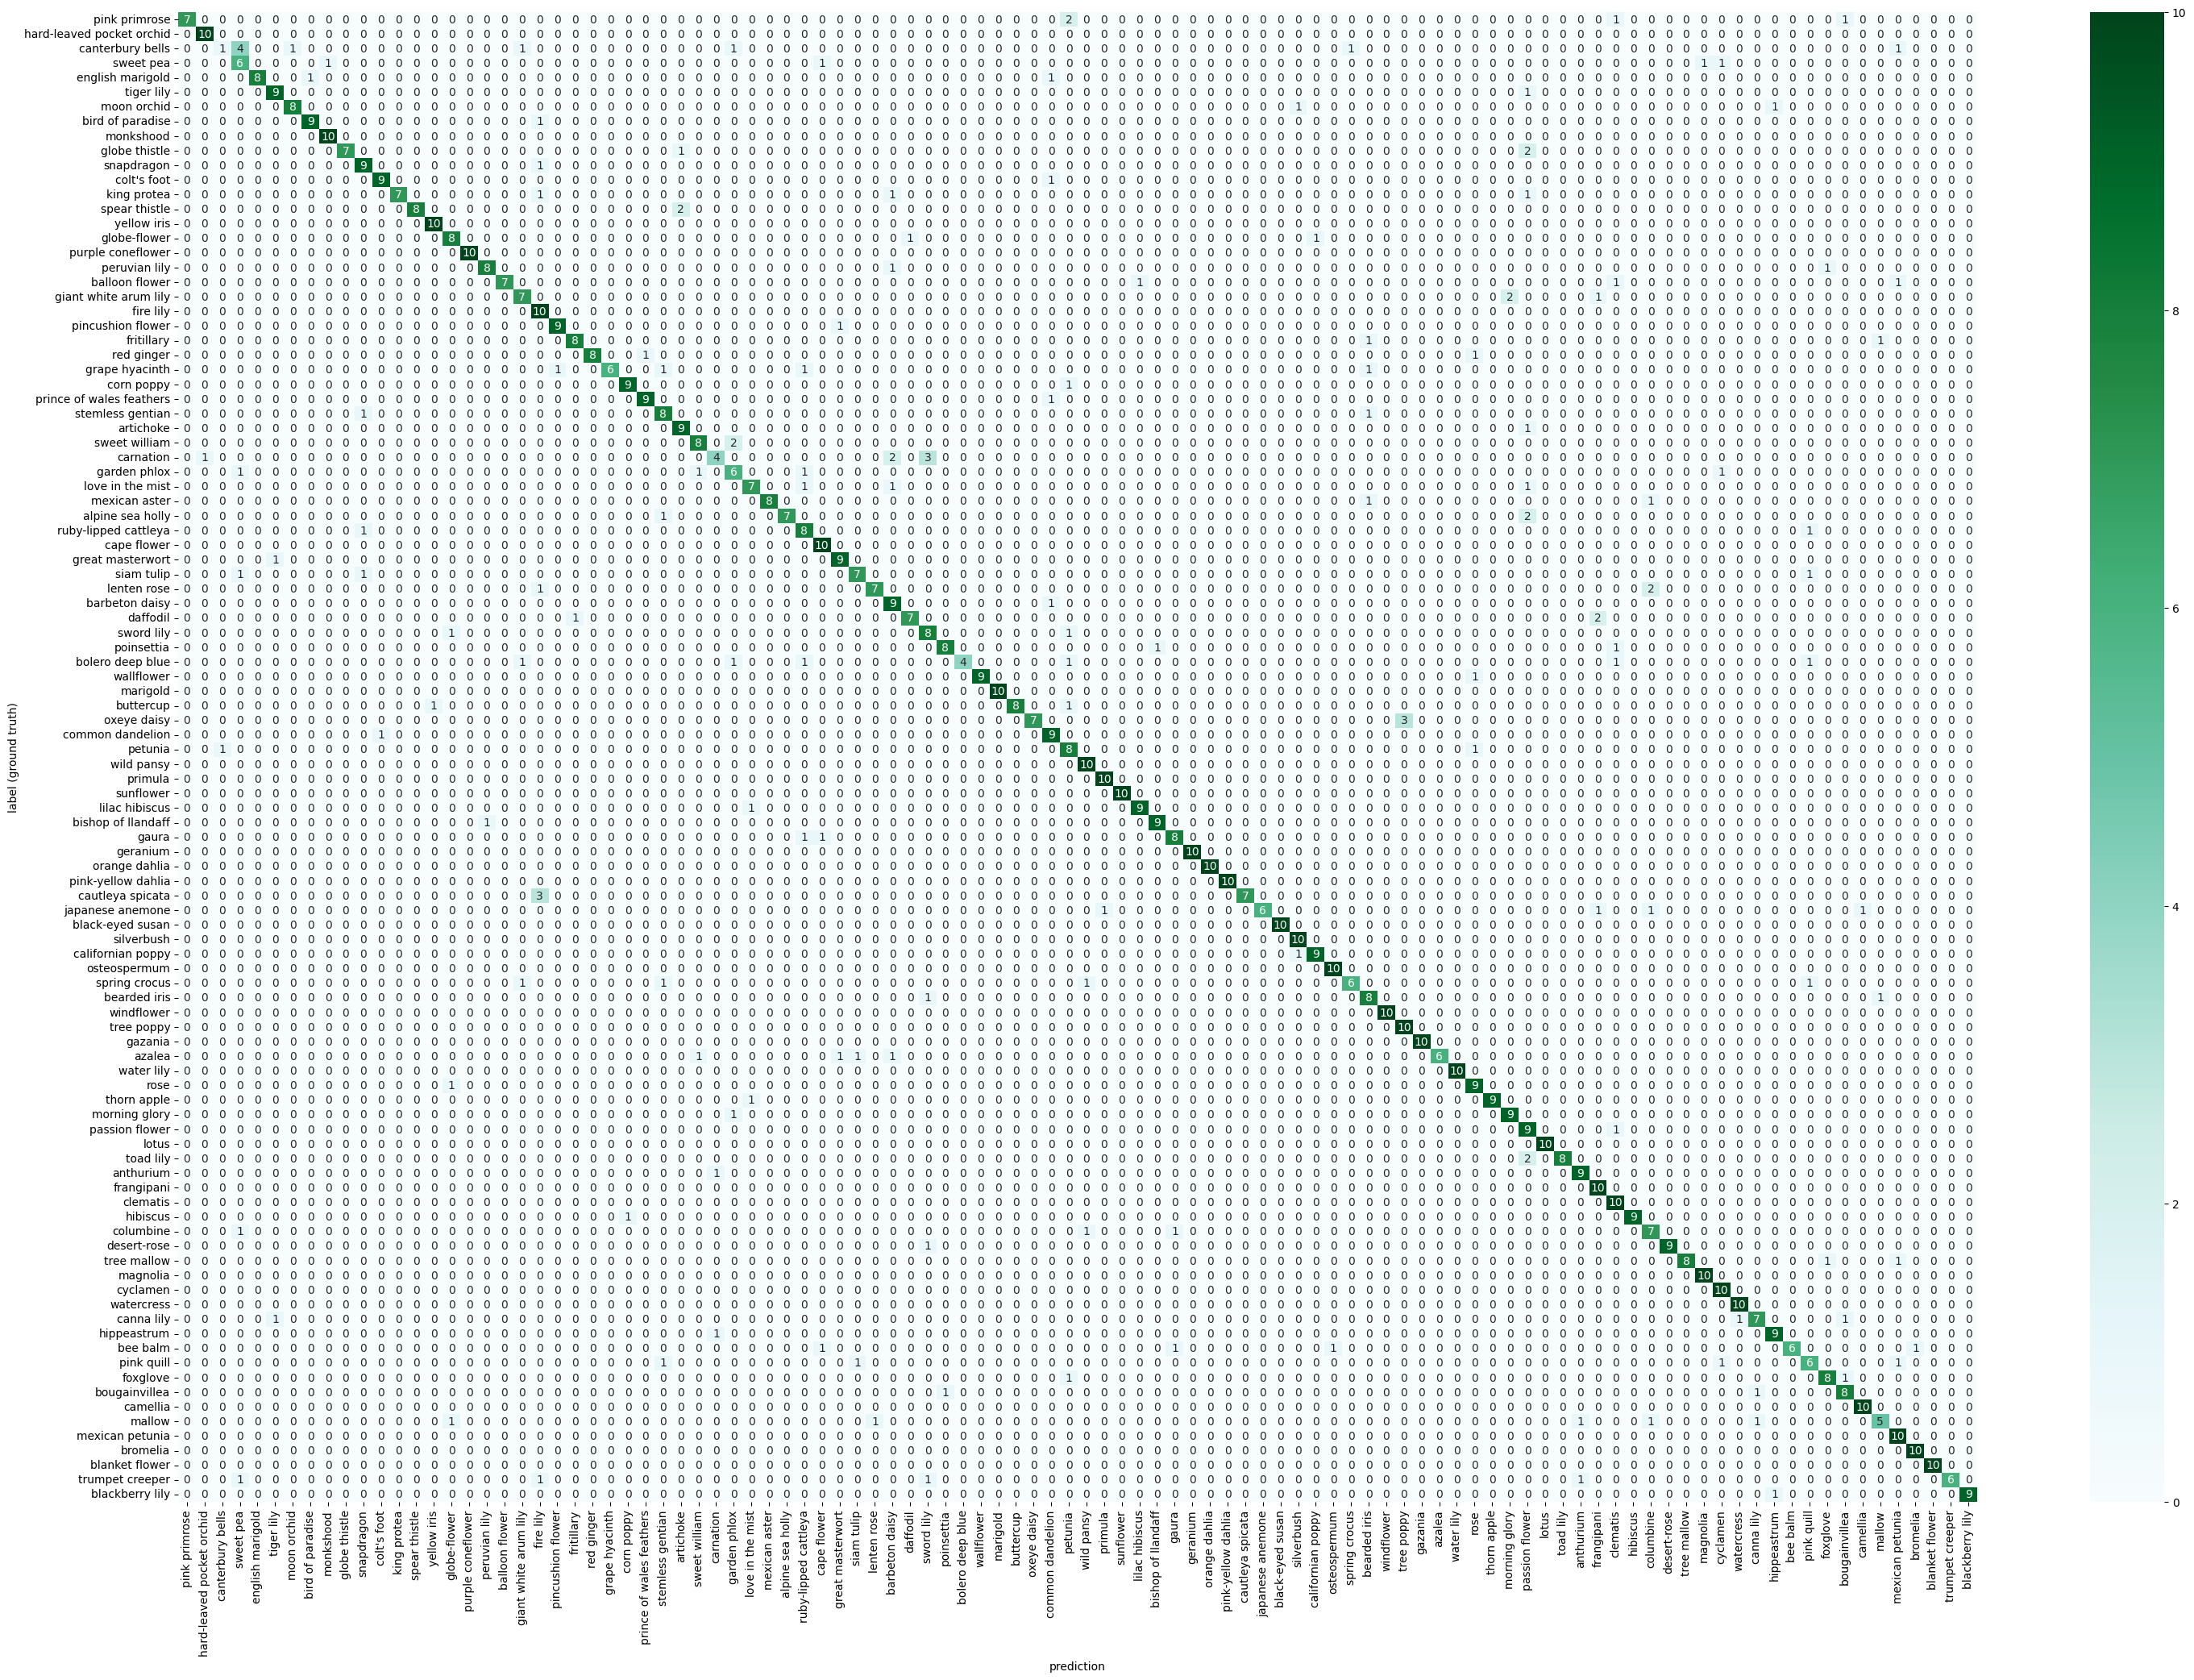

In [17]:
model.eval()

# Initialize arrays to store predictions and ground truth
preds = np.zeros((1))
truth = np.zeros((1))

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(len(labels)):
            label = labels[i].item()  # Convert label tensor to an integer
            class_correct[label] += c[i].item()
            class_total[label] += 1

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (36,24))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")



Lab0

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 53*53)
        self.fc2 = nn.Linear(53 * 53, 16*53)
        self.fc3 = nn.Linear(16 * 53, 16*16)
        self.fc4 = nn.Linear(16*16,102)
        # you can try other module like dropout, batch normalization, etc to improve model.
        # And other activation function like sigmoid, tanh, etc.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# you can try other optimizer like Adam, RMSprop, etc.


In [19]:
criterion5 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Train


Epoch:1
	Batch:193 of 193, loss:3.100
Accuracy of the network on the test images: 8.53 %

Epoch:2
	Batch:193 of 193, loss:2.606
Accuracy of the network on the test images: 14.71 %

Epoch:3
	Batch:193 of 193, loss:2.728
Accuracy of the network on the test images: 24.90 %

Epoch:4
	Batch:193 of 193, loss:1.864
Accuracy of the network on the test images: 29.61 %

Epoch:5
	Batch:193 of 193, loss:2.330
Accuracy of the network on the test images: 31.27 %

Epoch:6
	Batch:193 of 193, loss:1.426
Accuracy of the network on the test images: 33.73 %

Epoch:7
	Batch:193 of 193, loss:3.206
Accuracy of the network on the test images: 34.02 %

Epoch:8
	Batch:193 of 193, loss:1.391
Accuracy of the network on the test images: 34.80 %

Epoch:9
	Batch:193 of 193, loss:1.611
Accuracy of the network on the test images: 37.84 %

Epoch:10
	Batch:193 of 193, loss:0.640
Accuracy of the network on the test images: 39.61 %

Epoch:11
	Batch:193 of 193, loss:0.775
Accuracy of the network on the test images: 38.73 

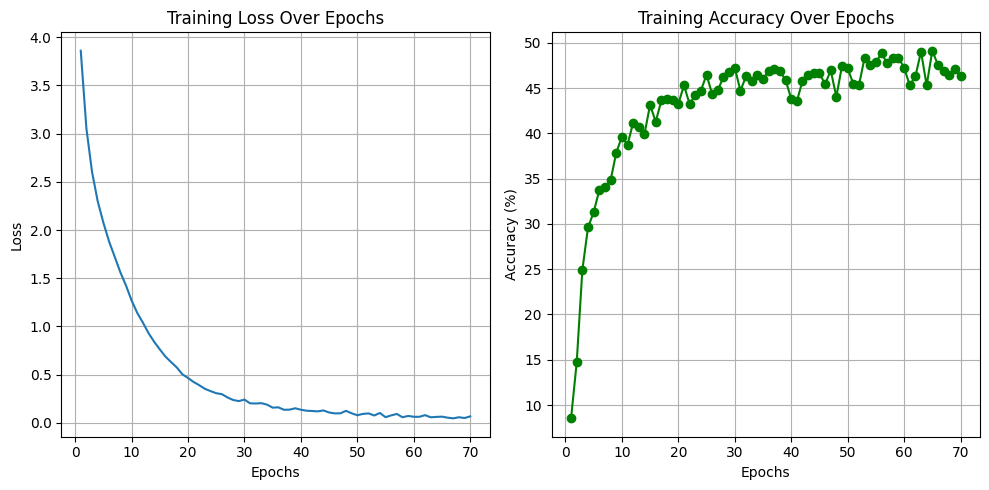

In [20]:
def train_model(model, criterion, optimizer, num_epochs):
    loss_history = []
    accuracy_history = []  
    early_stop_patience = 5
    best_validation_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.cuda()
        model.train()
       
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].cuda(), data[1].cuda()

            optimizer.zero_grad()

            outputs = model(inputs).cuda()
            loss = criterion5(outputs, labels).cuda()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

        loss_history.append(running_loss / len(trainloader))

        # calculate accuracy
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)  

        print(f'\nAccuracy of the network on the test images: {accuracy:.2f} %')

        if (epoch + 1) % 5 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_history': loss_history,
                'accuracy_history': accuracy_history  
            }
            checkpoint_filename = f'pth/resnet34_checkpoint_epoch{epoch+1}.pth'
            torch.save(checkpoint, checkpoint_filename)

    print('\nTraining finished')
    return loss_history, accuracy_history

loss_history, accuracy_history = train_model(model, criterion, optimizer, num_epochs=70)


import matplotlib.pyplot as plt

# 畫圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-',color="green")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid()

plt.tight_layout()
plt.show()


Test

Text(420.72222222222223, 0.5, 'label (ground truth)')

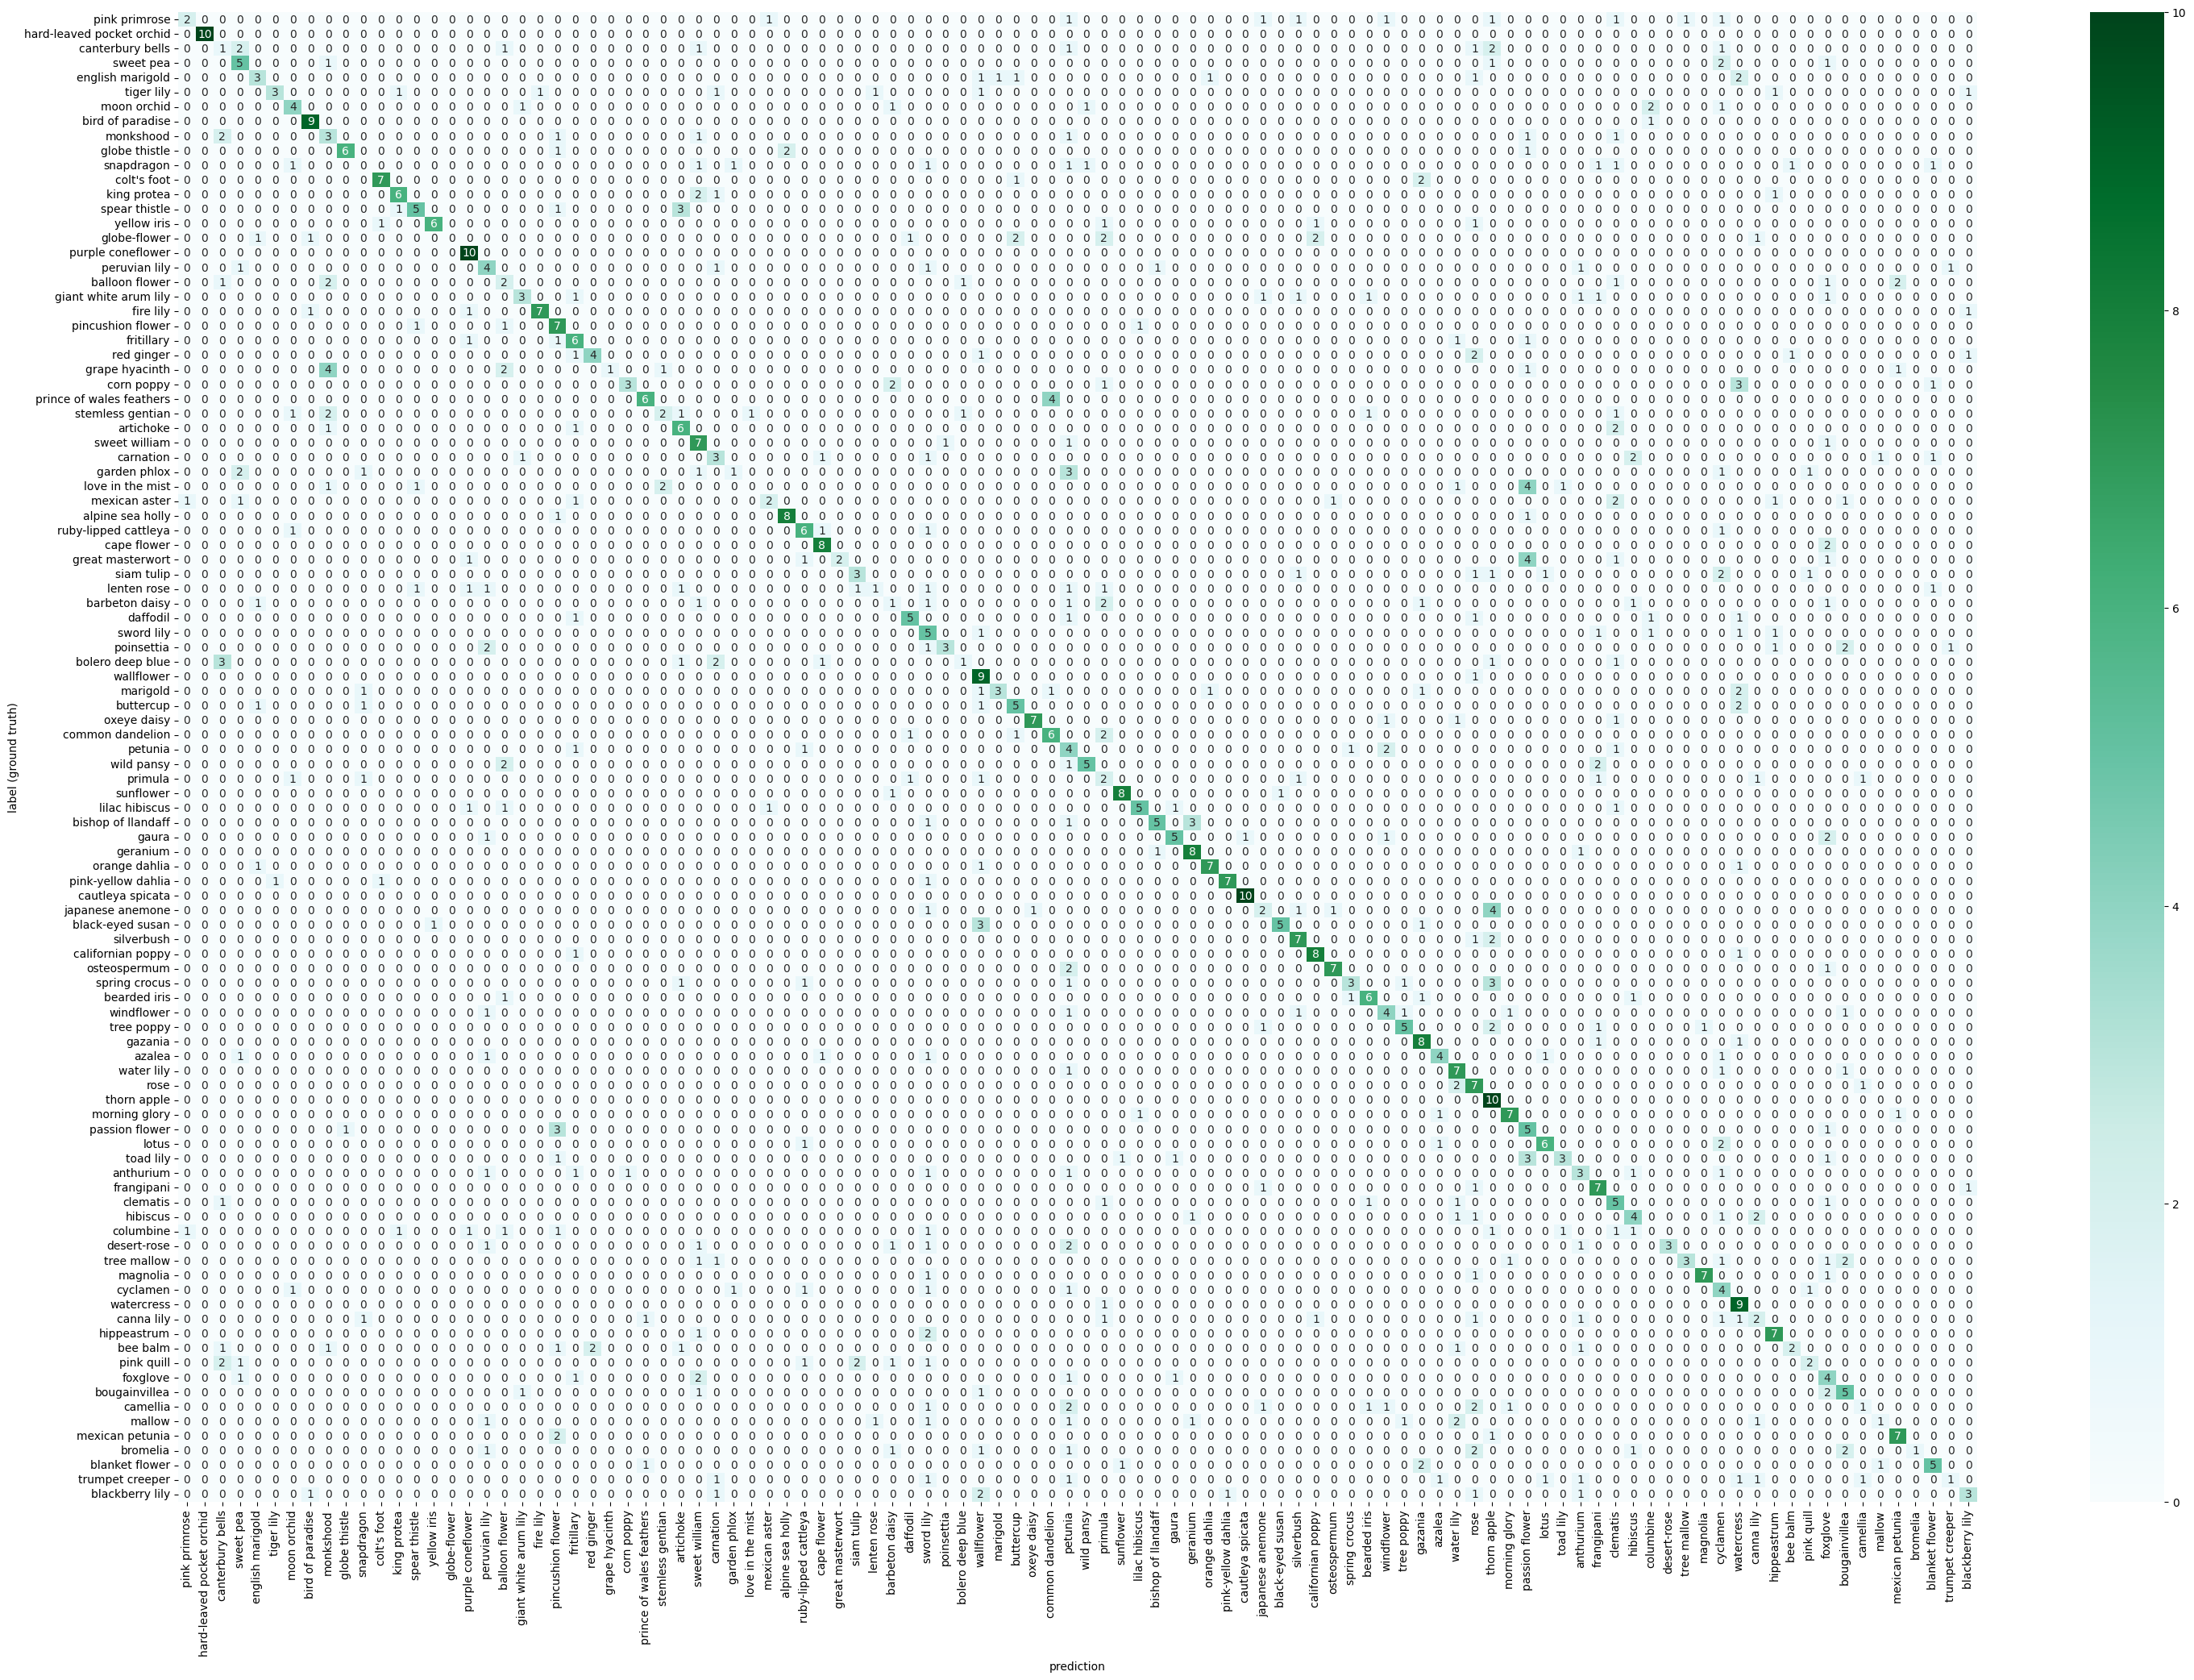

In [21]:



model.eval()

# Initialize arrays to store predictions and ground truth
preds = np.zeros((1))
truth = np.zeros((1))

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(len(labels)):
            label = labels[i].item()  # Convert label tensor to an integer
            class_correct[label] += c[i].item()
            class_total[label] += 1


# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (36,24))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")